# Multi-band light curves

In the [previous tutorial](./spectral.ipynb) we saw how to instantiate a [Star](spotter.star.Star) with a spectral map. Here, we demonstrate how to compute the light curves from such a map, which could originate from observing a star at different waveband.

We will assume that the intensity of the quiescent photosphere and its spots can be modeled as blackbodies with different temperatures.

In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt


def planck(wavelength, temperature, normalize=False):
    h = 6.62607004e-34  # Planck constant
    c = 299792458  # speed of light
    k = 1.38064852e-23  # Boltzmann constant
    f = (2 * h * c**2 / wavelength**5) / (
        jnp.exp(h * c / (wavelength * k * temperature)) - 1
    )
    return f / jnp.max(f) if normalize else f


wv = np.linspace(0.5e-6, 3e-6, 200)

We will make measurements in separate bands with a wavelength response function defined as a Gaussian 

In [8]:
def gaussian(x, mu, sigma):
    return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)


np.random.seed(1)
bands_mean = np.random.choice(wv, 3)
bands_response = gaussian(wv, bands_mean[:, None], 0.4e-6)

Let's visualize some spectra together with our wavebands.

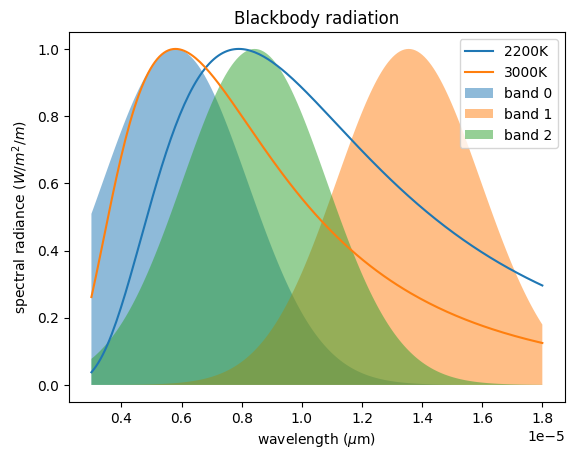

In [9]:
plt.subplot(
    111,
    xlabel="wavelength ($\mu$m)",
    ylabel="spectral radiance ($W/m^2/m$)",
    title="Blackbody radiation",
)
plt.plot(wv * 6, planck(wv, 2200, normalize=True), label="2200K")
plt.plot(wv * 6, planck(wv, 3000, normalize=True), label="3000K")
for i, b in enumerate(bands_response):
    plt.fill_between(wv * 6, b, alpha=0.5, label=f"band {i}")
plt.legend()

We then define a spotted surface using a Gaussian Process, as shown in the [GP tutorial](./surface_gp.ipynb)

In [10]:
import jax
import tinygp
from spotter.kernels import GreatCircleDistance, ActiveLatitude
from spotter import Star, show

star = Star.from_sides(20, period=1.0, u=(0.1, 0.2))

spot_kernel = 0.001 * tinygp.kernels.Matern52(0.1, distance=GreatCircleDistance())
kernel = ActiveLatitude(
    kernel=spot_kernel,
    latitude=0.5,
    sigma=0.1,
    symetric=True,
)

gp = tinygp.GaussianProcess(kernel, star.x, mean=1.0, diag=1e-8)
spot = gp.sample(jax.random.PRNGKey(2))
spot = np.clip(spot, 0.6, 0.97)

Here, we decided to clip the surface to artificially create darker smaller size spots. 

We then define the spectra of the pixel by using the `spot` map as a temperature map of the surface. Finally, we multiply the spectra of the pixels by the response function of each waveband

In [11]:
spectral_map = jax.vmap(lambda temp: planck(wv, temp))(spot * 3000)
measured_maps = (spectral_map[:, :, None] * bands_response.T[None, :, :]).mean(1)
star = star.set(y=measured_maps.T)

Let's have a look at the resulting maps

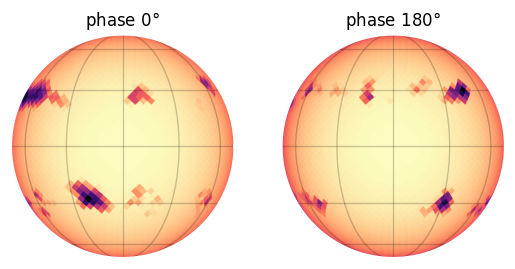

In [12]:
plt.subplot(121, title="phase $0\degree$")
show(star)
plt.subplot(122, title="phase $180\degree$")
show(star, np.pi)

We can now compute light curves observed at each waveband.

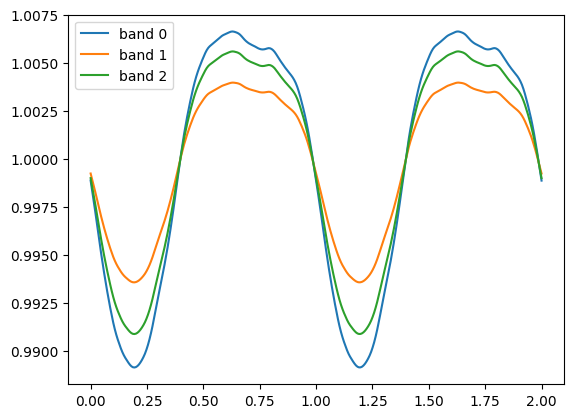

In [13]:
from spotter.light_curves import light_curve

time = np.linspace(0, 2.0, 300)
f = light_curve(star, time)
f /= np.mean(f, 1)[:, None]
for i in range(f.shape[0]):
    plt.plot(time, f[i], label=f"band {i}")
_ = plt.legend()